<!-- # CMPUT 200 Fall 2024  Ethics of Data Science and AI
 -->
# Assignment 2: Fairness Analysis of a Dataset

***
- **FIRST name**: Eshaan
- **LAST name**: Krishna
- **Student ID**: 1823454
- **Dataset**: adult.csv

Leave blank if individual:
- **Group member names**:
- **Group member student IDs**:
***

In this assignment, you will explore the different fairness metrics learnt in class using a dataset of your choice. Before beginning, you will have to inspect the data and determine the variable of interest (i.e. the outcome) and at least two sensitive features. After each step of your analysis, you will write an in-depth analysis of your results.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the primary variable of interest of your dataset
3. Reproduce the logistic regression model  and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

### Instructions
<!-- **Deadline.**  This assignment is due at ****.  Please check the syllabus for late submissions. -->
You are expected to write clear, detailed, and complete answers when analysing your data. Lack of this may result in point deductions.

**Reminder.** You must submit your own work.  The collaboration policy for the assignments is Consultation Collaboration. You may verbally discuss concepts with your classmates, without exchanging written text, code, or detailed advice.  You must develop your own solution and **submit your own work**.  This means that you **cannot** get your solution from AI tools.   All sources of information used including books, websites, students you talked to, must be cited in the submission.  Please see the course FAQ document for details on this collaboration policy.  We will adhere to current Faculty of Science guidelines on dealing with suspected cases of plagiarism.

You must use this notebook to complete your assignment. You will execute the questions in the notebook. The questions might ask for a short answer in text form or for you to write and execute a piece of code. Make sure you enter your answer in either case only in the cell provided. Do not use a different cell and do not create a new cell. Creating new cells for your code is not compatible with the auto-grading system we are using and thus your assignment will not get grading properly and you will lose marks for that question.

Your submitted notebook should run on our local installation.  So if you are importing packages not listed in the notebook or using local data files not included in the assignment package, make sure the notebook is self-contained with a requirements.txt file or cells in the notebook itself to install the extra packages.  If we cannot run your notebook, you will lose 50% of the marks, and any additional marks that may be lost due to wrong answers.

### Submission Instructions
When you are done, you will submit your work from the notebook. Make sure to save your notebook before running it, and then submit on Canvas the notebook file with your work completed. Name your file with your **Student ID number** and the assignment number (ex: 1234567_A2.ipynb). Failure to do so will result in a zero!

In [1]:
# Don't change this cell; just run it.
import numpy as np
from numpy.random import default_rng
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

# These lines do some fancy plotting magic.
import matplotlib
# This is a magic function that renders the figure in the notebook, instead of displaying a dump of the figure object.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
# Don't change this cell; just run it.
rng_seed = 42
rng = default_rng(rng_seed)
rngstate = np.random.RandomState(rng_seed)

## Data
**Question 1.** We will first load the data, carry out some cleaning and pre-processing, and inspect the data to understand what exploratory steps we will take. Name the DataFrame `df_init`.

In [3]:
# YOUR CODE HERE
file_path = 'adult.csv'  # Path to the uploaded CSV file
df_init = pd.read_csv(file_path)  # Load the dataset into a DataFrame

# Replace '?' with NaN for proper handling of missing values
df_init.replace('?', np.nan, inplace=True)

# Display all column names
print("\nColumn Names:")
print(df_init.columns.tolist())

# Display basic statistics and information
print("\nDataset info:")
print(df_init.info())

# Count the number of categorical, integer, and binary variables
num_categorical = df_init.select_dtypes(include=['object']).shape[1]
num_integer = df_init.select_dtypes(include=['int']).shape[1]

# For binary variables, we assume they are those columns where the unique count is 2
num_binary = df_init.select_dtypes(include=['object', 'int']).apply(lambda x: x.nunique() == 2).sum()

# Print summary of dataset
print("\nSummary of the Dataset:")
print(f"Number of Categorical Variables (out of which 2 are Binary): {num_categorical}")
print(f"Number of Integer Variables: {num_integer}")
print(f"Number of Binary Variables: {num_binary}")

# Count and display the number of missing entries for each column
missing_values = df_init.isnull().sum()

print("\nNumber of Missing Entries for Each Column:")
print(missing_values[missing_values > 0])

print("Shape: ", df_init.shape)
df_init.head(5)


Column Names:
['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


**Question 1.1.** Describe your data and its purpose. What are the sensitive variables, features, and target variables? Are there any latent variables?

**Description of the Data and Its Purpose**:
The dataset is the "Adult" dataset.  It contains demographic and employment-related attributes. Its purpose is to predict whether an individual's income exceeds $50K annually based on demographic and employment-related attributes. It is widely used for classification tasks, such as exploring the relationship between socioeconomic factors and income, and evaluating fairness in machine learning models.

**Purpose of the Dataset:**

The purpose of this dataset is to classify individuals into one of two income groups:

Annual income greater than 50K USD.

Annual income less than or equal to 50K USD.

This classification task helps in understanding the influence of various demographic and employment factors on an individual's income, which can be useful in social science research, economic studies, and employment analysis.

**Key Variables:**

**Sensitive Variables:**

These are the features that might raise concerns if used in decision-making processes, as they are directly related to individual characteristics that should be treated with extra care to avoid discrimination or bias:

sex:
The gender of the individual (Male/Female).

race:
The race/ethnicity of the individual (White, Black, Asian-Pac-Islander, Amer-Indian-Eskimo, Other).

native.country:
The country of origin, which could relate to nationality or ethnicity (e.g., United States, Cambodia, Mexico, etc.).
These variables are considered sensitive because they can potentially lead to discrimination or biased outcomes in models that use them, especially in real-world applications like hiring or salary determination.

**Features:**

These are the independent variables used to predict the target variable (income).

age: Age of the individual (numeric) (Sometimes may be sensitive)

workclass: Type of employment (Private, Self-emp-not-inc, Government, etc.).

fnlwgt: The "final weight" assigned to the individual for statistical analysis (numeric).

education: The highest level of education attained (e.g., Bachelors, Masters, PhD).

education.num: The numeric representation of education level (e.g., 13 for Bachelors, 16 for Doctorate).

marital.status: Marital status of the individual (e.g., Married-civ-spouse, Divorced).

occupation: Job category (e.g., Tech-support, Craft-repair, Prof-specialty).

relationship: Relationship status (e.g., Wife, Own-child).

capital.gain: Capital gains earned (numeric).

capital.loss: Capital losses incurred (numeric).

hours.per.week: The number of hours worked per week (numeric).

These features are the primary predictors used in the model to predict income.


**Target Variable:**

Income:(Numeric)

Greater than 50K: Annual income greater than 50K USD.

Annual income less than or equal to 50K USD.

This is a binary classification target variable, and the model's task is to predict which income group an individual belongs to based on their features.

**Latent Variables**

Latent variables are not directly measured in the dataset but might influence observed features. Examples include:

Socioeconomic Status: Influenced by education, occupation, and income.

Cultural Background: Reflected through race and native country.

Access to Opportunities: Tied to education, capital gain/loss, and workclass.

Workplace Discrimination: Variables like occupation, sex, and race may uncover latent biases or discrimination that may affect salary and career progression, especially if used in predictive models.

It is crucial, in every data analysis project, to have a good understanding of the data.  This includes:  how the data was collected, what sources the data originate from, how data were merged, what the data columns refer to, etc.  

**Question 2.** Do some investigating online about your dataset. Do they provide a methodology on how the data was collected? How was it analysed? Describe your findings below. (If your data does not have a methodology, describe how you would collect and analyse the data yourself).


The Adult dataset, collected by the U.S. Census Bureau, includes demographic and employment data to predict whether an individual’s income exceeds $50K annually. It is widely used for classification tasks to analyze the impact of various factors on income.

**Data Collection:**
Source: U.S. Census Bureau survey data.

Method: The dataset was collected through surveys, where respondents provided information regarding their demographic details (age, race, sex, education, etc.), employment status (workclass, occupation, hours worked), and income.

Data: Contains 32,561 entries with 15 features, including both numeric (e.g., age, hours worked) and categorical variables (e.g., race, workclass)

Data Sampling: It was designed to be a representative sample of the population based on census data, but it should be noted that any biases such as underrepresentation of certain demographics, may influence the analysis.

Preprocessing: In its raw form, some entries contain missing values, particularly in columns such as workclass, occupation, and native.country. These are often represented by the symbol "?", which requires proper handling (such as imputation or removal) during data preprocessing.

TagrThe income variable is the target variable, where the classification goal is to determine whether a person earns more than $50K a year based on these features.

**Analysis Method:**

Exploratory Data Analysis (EDA): Summary statistics and visualizations to explore relationships and distributions.

Feature Engineering: Categorical variables are encoded, and missing data is handled via imputation or removal.

Modeling: Algorithms like logistic regression or decision trees predict income classification. Models are evaluated using metrics like accuracy and F1-score.

Fairness: Ethical considerations are essential, as sensitive variables like race, sex, and nationality can lead to biased models. Fairness metrics are often applied.

**If I Were to Collect the Data:**

**Data Collection:**

Sampling: I would ensure that the data is collected from a diverse sample of individuals, considering factors such as age, gender, ethnicity, income level, and geographical location to make the sample representative of the population.

Survey Design: I would design a structured survey to collect demographic, educational, employment, and income-related data. This survey would aim to reduce bias in the collection process and ensure anonymity and ethical considerations, especially for sensitive attributes like race and gender.

Data Privacy: I would ensure that any personally identifiable information is anonymized and that the data collection process adheres to data protection regulations to respect individual privacy.

**Data Analysis:**

EDA: I would perform EDA to examine the distributions, relationships between variables, and any potential outliers or anomalies in the dataset.

Handling missing Data: I would handle missing data by either imputing values (for numerical or categorical variables) or removing rows/columns with excessive missing values if necessary.

Categorical Variables: I would transform categorical variables using encoding techniques and scale/normalize continuous variables for compatibility with machine learning algorithms.

Modeling: I would apply several machine learning models (e.g., logistic regression)and evaluate their performance using cross-validation and appropriate evaluation metrics.

Fairness Analysis: Given the sensitive variables, I would analyze the models for fairness and biases based on demographic factors (e.g., ensuring that the model does not unfairly favor one group over others).

### Data pre-processing
**Question 3.** You will now follow your dataset's methodology in pre-processing the data.  Note that your data may not be already filtered, so there may be rows that are not needed or missing values (NaN).  In your pre-processing, first retain only relevant columns for ease of analysis and inspection.  Relevant columns are those that you will need for analysis in this assignment - please read the whole assignment once over to determine which columns to retain.   You will need to retain all columns with sensitive features, the output columns, and other columns that contain features needed for the analysis.  Remember, it's always a good idea to check first all the columns and do any investigation into your dataset, like you were asked in Question 2.  Once you've retained the columns you want, remove the rows that are missing data (if needed).  

Next, determine if you have to do any more filtering (e.g. maybe you only want to consider individuals between 20 and 30 years old). Also decide if there are any any values that you want to remove (e.g. maybe you want to remove people classified as '0' for a medical condition).

In [4]:
cols_retain = []


# YOUR CODE HERE
# Retain relevant columns by defining cols_retain
cols_retain = [
    'age', 'workclass', 'education', 'education.num', 'marital.status',
    'occupation', 'relationship', 'race', 'sex', 'capital.gain',
    'capital.loss', 'hours.per.week', 'native.country', 'income'
]
df_filtered = df_init[cols_retain].copy()

# Handle Missing Values
df_filtered.replace('?', np.nan, inplace=True)
df_filtered.dropna(inplace=True)
print(df_filtered.shape)

# Apply Filtering (Optional)
df_filtered= df_filtered[(df_filtered['age'] >= 20) & (df_filtered['age'] <= 60)]
print(df_filtered.shape)

# Additional Filtering (if needed)
# Remove rows with zero values in 'capital-gain' and 'capital-loss'
df_filtered = df_filtered[(df_filtered['capital.gain'] > 0) | (df_filtered['capital.loss'] > 0)]
# Display the preprocessed dataset
print("Shape of the filtered DataFrame:", df_filtered.shape)
df_filtered.head(5)


(30162, 14)
(26987, 14)
Shape of the filtered DataFrame: (3540, 14)


,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
10,45,Private,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,>50K


**Question 3.1.** We will be working with your dataset's variable of interest, which is the output, or label.  You would have determined what this should be in the previous questions.  Let's first be certain the values are numeric.  You would use `pd.to_numeric`.  Note that there might be NaN values, and if so, you should drop those rows.

In [ ]:
# YOUR CODE HERE
# Convert the 'income' column to numeric values (0 for <=50K, 1 for >50K)
df_filtered['income'] = df_filtered['income'].map({'<=50K': 0, '>50K': 1})

# Ensure the 'income' column is numeric
df_filtered['income'] = pd.to_numeric(df_filtered['income'], errors='coerce')

# Drop rows with NaN values in the 'income' column
df_filtered.dropna(subset=['income'], inplace=True)

# Verify the result
print("Unique values in 'income' after conversion:", df_filtered['income'].unique())
print("Shape of the filtered DataFrame after conversion:", df_filtered.shape)

# Display the first few rows to check the changes
df_filtered.head()


Unique values in 'income' after conversion: [0 1]
Shape of the filtered DataFrame after conversion: (3540, 14)


,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
3,54,Private,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0
5,34,Private,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,0
6,38,Private,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,0
10,45,Private,Doctorate,16,Divorced,Prof-specialty,Unmarried,Black,Female,0,3004,35,United-States,1


### Data exploration
Let us now explore the statistics of the data.  Your data contains a variable of interest, which is the output.  Our goal is to compare the analysis of these outputs with the outputs of a logistic regression model we will build ourselves.

We will plot the distribution of the variable of interest according to the first sensitive feature (that you defined in question 1) to see how it differs across different subgroups.

**Question 4.** Let's first create dataframes that are specific to the different subgroups of your sensitive variable.  First choose In the cell below, create the new dataframes `df_1` and `df_2` so that `df_1` holds all the rows that correspond to the first subgroup and `df_2` holds all the rows that correspond to the second subgroup. If there are more than 2 subgroups, find a way to categorize them into two categories. You may change the names so that it's more specific to your dataset.

In [ ]:
# YOUR CODE HERE
# Create two new dataframes: one for Females (df_1) and one for Males (df_2)
df_1 = df_filtered[df_filtered['sex'] == 'Female'].copy()  # Data for females
df_2 = df_filtered[df_filtered['sex'] == 'Male'].copy()  # Data for males

# Verify the shape of the new dataframes
print("Shape of df_1 (Female subgroup):", df_1.shape)
print("Shape of df_2 (Male subgroup):", df_2.shape)

Shape of df_1 (Female subgroup): (792, 14)
Shape of df_2 (Male subgroup): (2748, 14)


**Question 4.1.** Now we will plot histograms for these new dataframes.  The histogram will have the variable of interest (output varialbe) on the x axis, n bins corresponding to the n values possible. The y axis will be the _proportion_ of individuals of each subgroup that have that variable of interest.  So the y values for each subgroup will be the number of individuals having a given value divided by the total number of individuals of that subgroup.

You can choose how you want to represent the histograms:  separate sub plots side by side, or all on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

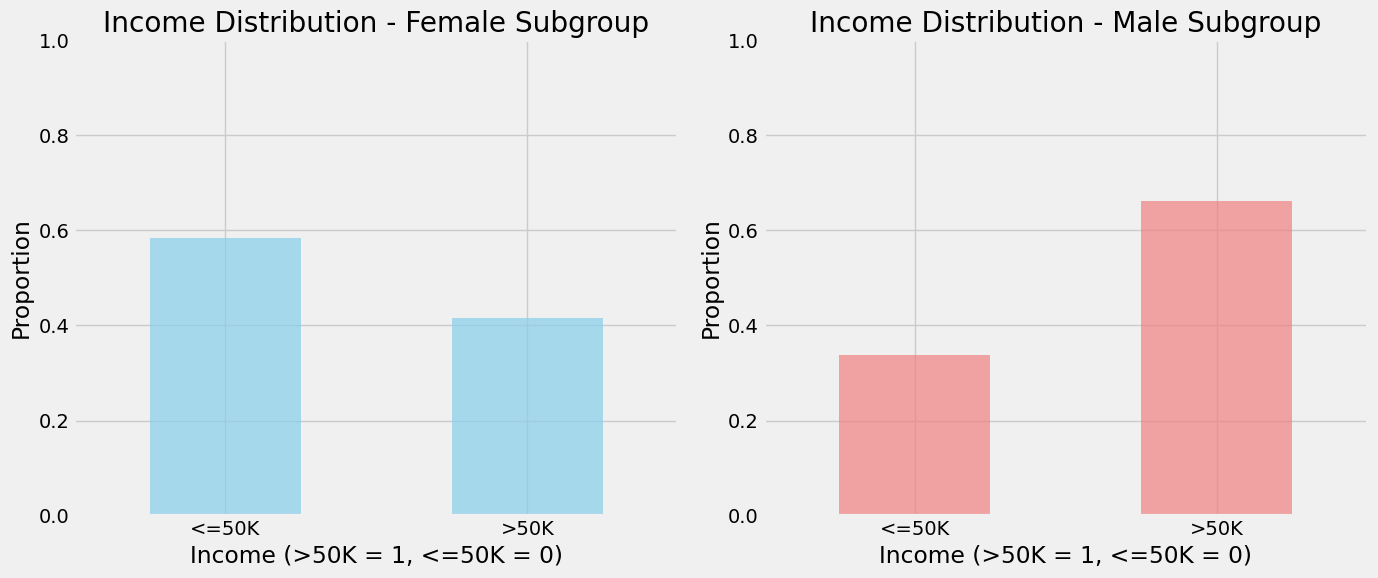

In [ ]:
# YOUR CODE HERE
# Plot histograms for the 'income' variable in df_1 and df_2
plt.figure(figsize=(14, 6))

# Plot histogram for df_1 (Female subgroup)
plt.subplot(1, 2, 1)
df_1['income'].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Income Distribution - Female Subgroup')
plt.xlabel('Income (>50K = 1, <=50K = 0)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0)
plt.ylim(0, 1)  # Ensure same y-axis scale

# Plot histogram for df_2 (Male subgroup)
plt.subplot(1, 2, 2)
df_2['income'].value_counts(normalize=True).sort_index().plot(kind='bar', color='lightcoral', alpha=0.7)
plt.title('Income Distribution - Male Subgroup')
plt.xlabel('Income (>50K = 1, <=50K = 0)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0)
plt.ylim(0, 1)  # Ensure same y-axis scale

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

**Question 4.2.** Describe the plots, especially any differences you see between them.  What does this tell you about the distribution of the variable of interest with respect to the sensitive feature?

The plots represent the income distribution (categorized as <=50K or >50K) for two subgroups based on the sensitive feature, gender (Female and Male).

**Description of plots:**

Female Subgroup (Left Plot):

The proportions of individuals earning <=50K and >50K are almost equal.
Slightly more individuals fall into the <=50K income category compared to >50K.

Male Subgroup (Right Plot):

There is a notable difference between the proportions.
A significantly larger proportion of individuals fall into the >50K income category compared to <=50K.

**Key Differences:**

The income distribution for females is balanced, with nearly equal proportions in both income categories.

The income distribution for males is skewed, with a much larger proportion of individuals earning >50K.

**Interpretation:**

This suggests a potential disparity in income levels between genders:
Males appear to have a higher likelihood of earning >50K compared to females. This could indicate a gender-based inequality or bias in income distribution, which might result from societal, structural, or dataset-specific factors.

**Importance: **

Understanding this distribution is crucial for evaluating fairness in the system or model that uses this data. If these income disparities influence decision-making, it could lead to biased outcomes, highlighting the need to address potential sources of bias in the data or system.

We will now consider the second sensitive feature.  Follow the same steps as above.

**Question 5.** Create dataframes that are specific to the subgroups for your second sensitive feature.  In the cell below, create the new dataframes `df_a` and `df_b` so that `df_a` holds all the rows that correspond to the first subgroup and `df_b` holds all the rows that correspond to the second subgroup. If there are more than 2 subgroups, find a way to categorize them into two categories. You may change the names so that it's more specific to your dataset.

In [ ]:
# YOUR CODE HERE
df_a = df_filtered[df_filtered['race'] == 'White']  # Subgroup 1: White individuals
df_b = df_filtered[df_filtered['race'] != 'White']  # Subgroup 2: Non-White individuals

# Display the shape of both subgroups
print("Shape of df_a (White subgroup):", df_a.shape)
print("Shape of df_b (Non-White subgroup):", df_b.shape)

Shape of df_a (White subgroup): (3156, 14)
Shape of df_b (Non-White subgroup): (384, 14)


**Question 5.1.** Now we will plot histograms for these new dataframes.  The histogram will have the variable of interest (output variable) on the x axis, n bins corresponding to the n values possible. The y axis will be the _proportion_ of individuals of each subgroup that have that variable of interest.  So the y values for each subgroup will be the number of individuals having a given value divided by the total number of individuals of that subgroup.

You can choose how you want to represent the histograms:  separate sub plots side by side, or all on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

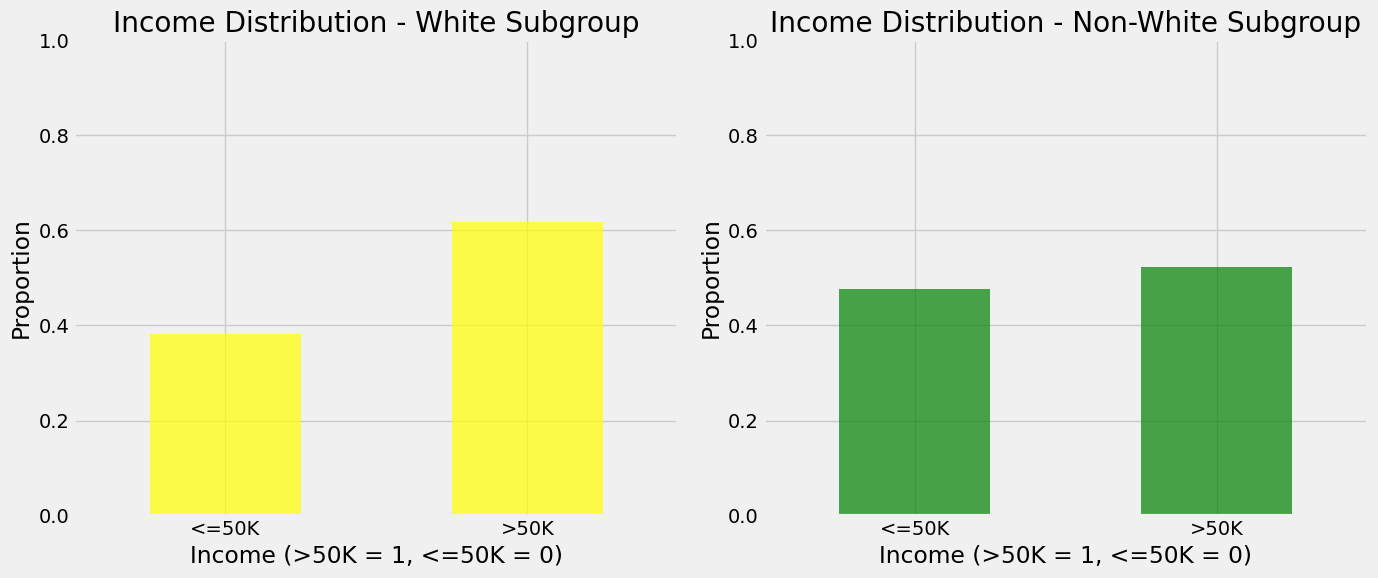

In [ ]:
# YOUR CODE HERE
# Plot histograms for the 'income' variable in df_a and df_b
plt.figure(figsize=(14, 6))

# Plot histogram for df_a (White subgroup)
plt.subplot(1, 2, 1)
df_a['income'].value_counts(normalize=True).sort_index().plot(kind='bar', color='yellow', alpha=0.7)
plt.title('Income Distribution - White Subgroup')
plt.xlabel('Income (>50K = 1, <=50K = 0)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0)
plt.ylim(0, 1)  # Ensure same y-axis scale

# Plot histogram for df_b (Non-White subgroup)
plt.subplot(1, 2, 2)
df_b['income'].value_counts(normalize=True).sort_index().plot(kind='bar', color='green', alpha=0.7)
plt.title('Income Distribution - Non-White Subgroup')
plt.xlabel('Income (>50K = 1, <=50K = 0)')
plt.ylabel('Proportion')
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0)
plt.ylim(0, 1)  # Ensure same y-axis scale

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

**Question 5.2.** Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the variable of interest with respect to the second sensitive feature?

The plots illustrate the income distribution (<=50K and >50K) for two subgroups based on the second sensitive feature, race (White and Non-White).

**Description of the plots:**

White Subgroup (Left Plot):

The proportion of individuals earning >50K is higher than those earning <=50K. The bar for >50K income is visibly larger, indicating a higher representation in this income category.

Non-White Subgroup (Right Plot):

The proportions of individuals in the <=50K and >50K categories are closer to equal.However, there is a slight dominance of the <=50K category compared to the >50K category.

**Key Differences:**
Income disparity between subgroups:
The White subgroup has a noticeably higher proportion of individuals earning >50K compared to <=50K.

The Non-White subgroup has a more balanced distribution, but individuals earning <=50K slightly outnumber those earning >50K.

**Interpretation:**
This indicates a potential racial disparity in income distribution:
White individuals are more likely to earn >50K compared to Non-White individuals. Non-White individuals have a relatively higher representation in the <=50K income category.

**Importance:**
Such disparities could reflect underlying societal inequities, systemic biases, or historical disadvantages affecting income levels. If this data is used in decision-making models, it might perpetuate or amplify these disparities unless explicitly addressed. Evaluating and mitigating these differences is essential to ensure fairness in outcomes.

## Fairness / Bias in the Dataset

Now we will develop our own logistic regression model to predict the output given the data and see how it does with respect to fairness metrics.

#### Pre-processing
We first have some preprocessing to do.

Logistic regression is used here as a classification algorithm, so it will give binary outputs. We will use `sklearn`'s logistic regression model which takes numerical input.  Your dataset's features may be categorical variables. If this is the case, we will have to convert the categorical features to numerical features.  We will use [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for this.

**Question 6.** Let's first set up a dataframe for the label, or target values. In the cell below extract that column into a separate dataframe, our target dataframe. Assign your answer to the variable `Y`.

In [ ]:
# YOUR CODE HERE
# Extract the target (label) variable into a separate dataframe
Y = df_filtered['income'].copy()

# Display the target dataframe
print("Target variable (Y) head:")
print(Y.head(5))

Target variable (Y) head:
3     0
4     0
5     0
6     0
10    1
Name: income, dtype: int64


**Question 6.1.** Now Let's set up the remaining data. Create another dataframe named `X` that contains every column *except* the target column.

In [ ]:
# YOUR CODE HERE
# Create the feature dataframe by dropping the 'income' column
X = df_filtered.drop(columns=['income']).copy()

# Display the first few rows of the feature dataframe
print("Feature dataframe (X) head:")
print(X.head())

Feature dataframe (X) head:
    age workclass     education  education.num marital.status  \
3    54   Private       7th-8th              4       Divorced   
4    41   Private  Some-college             10      Separated   
5    34   Private       HS-grad              9       Divorced   
6    38   Private          10th              6      Separated   
10   45   Private     Doctorate             16       Divorced   

           occupation relationship   race     sex  capital.gain  capital.loss  \
3   Machine-op-inspct    Unmarried  White  Female             0          3900   
4      Prof-specialty    Own-child  White  Female             0          3900   
5       Other-service    Unmarried  White  Female             0          3770   
6        Adm-clerical    Unmarried  White    Male             0          3770   
10     Prof-specialty    Unmarried  Black  Female             0          3004   

    hours.per.week native.country  
3               40  United-States  
4               40  Un

**Question 6.2.** Your analysis should only contain the features that you deem necessary. In the next cell, retain only these columns in our features dataframe `X`.

In [ ]:
cols_retain = []
# YOUR CODE HERE
cols_retain_features = [
    'age', 'workclass', 'education.num', 'marital.status','occupation','sex','capital.gain', 'capital.loss', 'hours.per.week',
    'race', 'native.country']


# Retain only the necessary columns in the features dataframe (X)
X = X[cols_retain_features].copy()

# Display the first few rows of the updated feature dataframe
print("Updated feature dataframe (X) head:")
print(X.head())


Updated feature dataframe (X) head:
    age workclass  education.num marital.status         occupation     sex  \
3    54   Private              4       Divorced  Machine-op-inspct  Female   
4    41   Private             10      Separated     Prof-specialty  Female   
5    34   Private              9       Divorced      Other-service  Female   
6    38   Private              6      Separated       Adm-clerical    Male   
10   45   Private             16       Divorced     Prof-specialty  Female   

    capital.gain  capital.loss  hours.per.week   race native.country  
3              0          3900              40  White  United-States  
4              0          3900              40  White  United-States  
5              0          3770              45  White  United-States  
6              0          3770              40  White  United-States  
10             0          3004              35  Black  United-States  


Since we will use `sklearn`'s logistic regression model, we need all our data to be numerical values.  Let's first examine the column types.

Run the following cell to examine the data.

In [ ]:
X.dtypes

,0
age,int64
workclass,object
education.num,int64
marital.status,object
occupation,object
sex,object
capital.gain,int64
capital.loss,int64
hours.per.week,int64
race,object


**Question 6.3.** A data type of `object` indicates that the column is categorical.  We will need to convert these to numerical.  We will use one hot encoding on the categorical features. We first separate the numerical and categorical featues using `selector`.  Then we transform the categorial features using one hot encoding and we normalize the numerical features using a scalar.  See for instance here for help on this step: <https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py>

In [ ]:
# we will need the following modules
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# YOUR CODE HERE
# Separate the categorical and numerical features using selectors
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()  # Categorical features

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply the transformations to the feature dataframe X
X_transformed = preprocessor.fit_transform(X)

# Display the transformed data (as a sparse matrix for efficiency)
print("Transformed feature matrix:")
print(X_transformed.shape)


Transformed feature matrix:
(3540, 77)


**Question 6.4.** Now we set up the pipeline for our model.  You can refer to the url provided above for help with this step.  You may also need to set `max_iter` to make sure the model converges. Assign your answer to the variable `model`.


In [ ]:
# make sure you import the models needed for this step
# YOUR CODE HERE
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Set up the pipeline with preprocessing and logistic regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # The preprocessing steps (scaling & encoding)
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression classifier with max_iter set
])
# Check the model
print(f"Model pipeline: {model}")

Model pipeline: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupation', 'sex', 'race',
                                                   'native.country'])])),
                ('classifier', LogisticRegression(max_iter=1000))])


**Question 6.5.** Now split your dataset into train and test datasets, with the test set being 25% of the whole dataset. Assign your answers to `X_train`, `X_test`, `Y_train`, `Y_test`.

In [ ]:
# import the module
from sklearn.model_selection import train_test_split

# YOUR CODE HERE
# Split the data into training and test sets (test size = 25%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
#Fit the model
model.fit(X_train, Y_train)

# Print the shapes to confirm the split
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

Training features shape: (2655, 11)
Test features shape: (885, 11)
Y_train shape: (2655,)
Y_test shape: (885,)


In [ ]:
# now we run the logistic regression we have set up
# Just run this cell

model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupation', 'sex', 'race',
                                                   'native.country'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

**Question 6.6.** Let's now predict on the test set and see what the performance metrics are.

In [ ]:
## write code to run the model on the test set;
## after running this cell, Y_test holds the true class labels for the test set
## set Y_pred to be the predicted labels

# YOUR CODE HERE
# YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# Predict the labels for the test set
Y_pred = model.predict(X_test)
print("Predicted labels (Y_pred):")
print(Y_pred[:50])  # Display the first 5 predictions

# Calculate performance metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Print the accuracy and other scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC-AUC
roc_auc = roc_auc_score(Y_test, Y_pred)
print(f'ROC-AUC: {roc_auc:.4f}')

# Print a detailed classification report (includes precision, recall, F1 score)
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Print confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))

cm=confusion_matrix(Y_test, Y_pred)
TN, FP, FN, TP = cm.ravel()
# Display the values
print(f"True Positive (TP): {TP}")
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")

# Compare the actual vs predicted values
comparison = pd.DataFrame({"Actual": Y_test, "Predicted": Y_pred})

# Display the first few rows of the comparison DataFrame
print("\nComparison of Actual vs Predicted:")
print(comparison.head(5))

Predicted labels (Y_pred):
[1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0
 0 1 1 0 1 1 0 1 1 1 1 0 1]
Accuracy: 0.8633
Precision: 0.8764
Recall: 0.9009
F1 Score: 0.8885
ROC-AUC: 0.8533

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82       350
           1       0.88      0.90      0.89       535

    accuracy                           0.86       885
   macro avg       0.86      0.85      0.86       885
weighted avg       0.86      0.86      0.86       885


Confusion Matrix:
 [[282  68]
 [ 53 482]]
True Positive (TP): 482
True Negative (TN): 282
False Positive (FP): 68
False Negative (FN): 53

Comparison of Actual vs Predicted:
      Actual  Predicted
821        1          1
360        1          1
1707       1          1
4167       0          0
2596       1          1


### Fairness metrics

Let's now examine the fairness metrics of this classifier.

Let's first convert `Y_pred` into a DataFrame for use later.

In [ ]:
Y_pred = pd.DataFrame(Y_pred, Y_test.index)
Y_pred.head()

,0
821,1
360,1
1707,1
4167,0
2596,1


**Question 7.** We will first extract the sensitive features into a new dataframe, `A`.  Since we are examining results on the test set, we extract this from `X_test`.

In [ ]:
# Just run this cell
# we will import packages we may need
from sklearn.metrics import confusion_matrix

In [ ]:
# In this cell, extract the sensitive features A

# YOUR CODE HERE
# Define the sensitive features (e.g., 'sex', 'race')
sensitive_features = ['sex', 'race']  # Modify this list as per your dataset

# Extract the sensitive features from the X_test dataframe
A = X_test[sensitive_features].copy()
# Display the first few rows of the new dataframe 'A' to verify the result
print("Sensitive Features DataFrame (A):")
print(A.head())

Sensitive Features DataFrame (A):
         sex                race
821     Male               White
360     Male               White
1707    Male               White
4167  Female  Asian-Pac-Islander
2596    Male               White


**Question 7.1.** Now let's write some functions to calculate the fairness metrics.  In particular, we want to calculate the true positive and false positive rates, and the positive label rate.

In [ ]:
def tpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    tpr : float
        The true positive rate for the individuals with s_feature = s_value

    For example, calling tpr_metric(Y_test, Y_pred, x, "condition","asthma") should return
    the true positive rate for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    tpr=0

    # YOUR CODE HERE
    # Filter based on the sensitive feature
    indices = x[x[s_feature] == s_value].index
    if len(indices) == 0:
        return 0.0  # or handle this case appropriately if no data matches

    # Ensure y_true and y_pred are aligned with the filtered indices
    y_true_filtered = y_true.loc[indices].values.flatten()
    y_pred_filtered = y_pred.loc[indices].values.flatten()

    # Calculate TP and FN
    tp = ((y_pred_filtered == 1) & (y_true_filtered == 1)).sum()
    fn = ((y_pred_filtered == 0) & (y_true_filtered == 1)).sum()
    print("TP",tp)
    print("FN",fn)

    # Calculate TPR
    tpr = float(tp)/ (tp + fn) if (tp + fn) > 0 else 0.0
    return tpr

In [ ]:
def fpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    fpr : float
        The false positive rate for the individuals with s_feature = s_value

    For example, calling fpr_metric(Y_test, Y_pred, x, "condition","asthma") should return
    the false positive rate for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    fpr=0

    # YOUR CODE HERE
    indices = x[x[s_feature] == s_value].index
    if len(indices) == 0:
        return 0.0  # Return 0.0 if there are no matching rows

    # Ensure y_true and y_pred are aligned with the filtered indices
    y_true_filtered = y_true.loc[indices].values.flatten()
    y_pred_filtered = y_pred.loc[indices].values.flatten()

    # Calculate False Positives (FP) and True Negatives (TN)
    fp = ((y_pred_filtered == 1) & (y_true_filtered == 0)).sum()
    tn = ((y_pred_filtered == 0) & (y_true_filtered == 0)).sum()
    print("FP",fp)
    print("TN",tn)

    # Calculate FPR
    fpr = float(fp) / (fp + tn) if (fp + tn) > 0 else 0.0
    return fpr

In [ ]:
def poslabel_metric(y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    poslabel : float
        The rate of a positive label for the individuals with s_feature = s_value
        This is P[y_pred=1|s_featue=s_value]

    For example, calling poslabel_metric(y_pred,x, "condition","asthma") should return
    the rate of positive labels for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_pred and x should correspond to the same rows, for example these could be Y_pred and X_test
    '''

    poslabel=0

    # YOUR CODE HERE
    # Filter the dataset by the sensitive feature value
    subset = x[x[s_feature] == s_value]

    # If the subset is empty, return 0 to avoid division by zero
    if len(subset) == 0:
        return 0  # No individuals in the subgroup

    # Align y_pred to the filtered subset using the index
    subset_y_pred = y_pred.loc[subset.index]

    # Count the number of positive predictions (y_pred == 1)
    positive_labels = (subset_y_pred == 1).sum()

    # Calculate the total number of individuals in the subset
    total = len(subset)

    # Compute the positive label rate (P[y_pred = 1 | s_feature = s_value])
    poslabel = positive_labels / total if total != 0 else 0
    return poslabel

You now have the functions necessary to determine the fairness metrics.
We will examine the difference in the parity definitions.
Specifically, we look at the following:
- demographic parity difference:  the gap in demographic parity between two given subgroups.  Here, it means the difference in the rate of positive label ( Pr[Y_pred = 1 | A=1] - Pr[Y_pred = 1 | A=0] between subgroups 1 and 0.)
- equal opportunity difference:  the difference in true positive rates
- equalized odds difference:  the difference in true positive rates and false positive rates. The output here is a vector, with the first element in the vector being the difference in true positive rates and the second element being the difference in false positive rates.

**Question 7.2.** For each of the following, write code to compute the metrics and write in text form your explanation of what you see - describe the metrics.  Is our model fair?  Why or why not?

1. First sensitive feature: subgroup 1 vs subgroup 2 </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference
2. Second sensitive feature:  subgroup a vs subgroup b </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference </br  >
3. Age:  young subgroup vs old subgroup (choose your own age ranges) </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference

In [ ]:
# Code and explanation for 1 here
# Demographic parity difference
# YOUR CODE HERE
#Calculate the positive label rate for each subgroup
poslabel1 = poslabel_metric(Y_pred, X_test, "sex", "Female")
poslabel2 = poslabel_metric(Y_pred, X_test, "sex", "Male")

# Demographic parity difference (difference in positive label rates)
demographic_parity = poslabel1 - poslabel2
print("Demographic Parity:", demographic_parity)

#Equal Opportunity Difference
# YOUR CODE HERE
# Calculate the True Positive Rates (TPR) for each subgroup
print("Female")
tpr1 = tpr_metric(Y_test, Y_pred, X_test, "sex", "Female")
print("Male")
tpr2 = tpr_metric(Y_test, Y_pred, X_test, "sex", "Male")

# Equal opportunity difference (difference in TPR)
eq_opp_diff = tpr1 - tpr2
print("Equal Opportunity Difference:", eq_opp_diff)

#Equalized odds difference
# YOUR CODE HERE
print("Female")
fpr1 = fpr_metric(Y_test, Y_pred, X_test, "sex", "Female")
print("Male")
fpr2 = fpr_metric(Y_test, Y_pred, X_test, "sex", "Male")

# Equalized odds difference (difference in TPR and FPR)
fpr_diff= fpr1 - fpr2
print("Equalized Odds Differences. TP, FP:", [eq_opp_diff, fpr_diff])

Demographic Parity: 0   -0.295061
dtype: float64
Female
TP 71
FN 13
Male
TP 411
FN 40
Equal Opportunity Difference: -0.06607010875303554
Female
FP 9
TN 110
Male
FP 59
TN 172
Equalized Odds Differences. TP, FP: [-0.06607010875303554, -0.17978100331041508]


Write your explanation below:

**Detailed Explanation of Fairness Metrics and Results (Subgroup Sex Female/ Male):**

In this analysis, we are evaluating a machine learning model's fairness by using three key fairness metrics: Demographic Parity Difference, Equal Opportunity Difference, and Equalized Odds Difference. These metrics help us understand whether the model treats different subgroups (in this case, based on the sensitive feature "sex" with subgroups "Female" and "Male") fairly or if there is any bias or disparity in its predictions.

**1.	Demographic Parity Difference:**

Demographic parity is a fairness criterion that requires the model to have the same positive prediction rate across different groups defined by a sensitive attribute (in this case, "sex"). The Demographic Parity Difference is calculated as the difference in the rate of positive predictions between two subgroups.

Demographic Parity: 0 -0.295061

This value tells us that there is a significant gap in the rate of positive predictions between the two subgroups. Females have a rate of positive predictions that is about 29.5% lower than that for Males.
Demographic parity is often seen as a fairness criterion in contexts where it’s important to ensure that individuals from different groups are treated equally in terms of the outcomes (Model’s predictions). A large disparity like this suggests that the model may be biased against the female subgroup, as it is assigning fewer positive predictions to females than males, potentially leading to unequal access to opportunities or outcomes based on gender.

**2. Equal Opportunity Difference:**

The Equal Opportunity fairness criterion focuses on ensuring that the model has equal True Positive Rates (TPR) across different groups. TPR is the proportion of actual positive cases that are correctly identified by the model. The Equal Opportunity Difference is the difference in TPR between the two subgroups.

Equal Opportunity Difference: -0.06607010875303554

This indicates that the True Positive Rate for females is 6.6% lower than for males. This means the model is less effective at correctly identifying positive cases for females than for males.
Equal Opportunity ensures that all groups, regardless of their sensitive attributes (here, sex), have an equal chance of being identified as positive when they truly are positive. A negative difference indicates that the model is failing to identify positive cases for females compared to males, which can be considered an unfair treatment of the female subgroup. The model might be underperforming for females, potentially leading to negative consequences for them in certain applications, such as healthcare or hiring, where being correctly identified as "positive" could have important outcomes.

**3. Equalized Odds Difference:**
Equalized odds requires that the model has equal True Positive Rates (TPR) and False Positive Rates (FPR) across all groups. FPR is the proportion of actual negative cases that are incorrectly classified as positive. The Equalized Odds Difference measures the difference in both TPR and FPR between two subgroups.

Equalized Odds Differences (TPR, FPR): [-0.06607010875303554, -0.17978100331041508]

TPR Difference: The difference in TPR is the same as the Equal Opportunity Difference, showing that the model has a 6.6% lower TPR for females than for males.

FPR Difference: The False Positive Rate for females is about 18% lower than for males. This means that females are less likely to be incorrectly classified as positive compared to males.

Equalized Odds ensures that the model performs equally well in identifying both true positives and true negatives for all groups. The results show that: The True Positive Rate (TPR) is worse for females than for males, suggesting that females are less likely to be correctly identified as positive cases. The False Positive Rate (FPR) is better for females, meaning females are less likely to be wrongly classified as positive when they are actually negative.

While a lower FPR for females might seem beneficial, it could also be a form of bias. It could indicate that the model is being overly cautious with females, potentially under-predicting positive outcomes for them, which may harm them in certain scenarios (e.g., fewer opportunities or benefits for females who deserve them).

**Overall Interpretation:**

Based on the metrics, the model is not fair.
1.	Demographic Parity: The model has a significant disparity in positive predictions between males and females. Females are significantly less likely to receive a positive prediction compared to males.
2.	Equal Opportunity: The model has a lower True Positive Rate for females compared to males, meaning it is less likely to correctly identify positive cases for females. This is an indication of unfair treatment for females in the model’s decision-making.
3.	Equalized Odds: The model has both a lower True Positive Rate and a lower False Positive Rate for females. The lower TPR indicates the model is less effective at identifying positive cases for females, while the lower FPR could indicate the model is underpredicting positives for females, leading to fewer opportunities or benefits.

**Conclusion: **

In conclusion, the model currently exhibits unfairness towards females in terms of both the positive prediction rate and the true positive rate, indicating the need for improvement in its fairness with respect to the sensitive feature "sex." The demographic parity difference and equal opportunity difference suggest that the model is biased in favor of the male subgroup. The equalized odds difference reveals an imbalance not only in the model’s ability to correctly identify positives but also in how it misclassifies negative cases.
In terms of fairness, the model may require adjustments, such as reweighting, resampling, or threshold adjustments, fairness constraints, Bias mitigation algorithms to ensure that it performs equitably across different sensitive subgroups.

**Calculations: **

TPR Female = 71/ (71+13),
TPR Male = 411/ (411+40)
FPR Female = 9/ (9+110)
FPR Female =59/ (59+172)
Equal opportunity = (TPR Female - TPR Male)
Odds: (TPR Fmale - TPR Male , FPR - Female-FPR Male)

In [ ]:
# Code and explanation for 2 here
# Demographic parity difference
# YOUR CODE HERE
X_test_copy = X_test.copy()
# Modify the 'race' column: Set all values except "White" to "Non-White"
X_test_copy.loc[X_test_copy['race'] != 'White', 'race'] = 'Non-White'

#Calculate the positive label rate for each subgroup
print("White")
demographic_parity_white = poslabel_metric(Y_pred, X_test_copy, "race", "White")
print("Non_White")
demographic_parity_nonwhite = poslabel_metric(Y_pred, X_test_copy, "race", "Non-White")

# Demographic parity difference (difference in positive label rates)
demographic_parity = demographic_parity_white - demographic_parity_nonwhite
print("Demographic Parity:", demographic_parity)

#Equal Opportunity Difference
# Calculate the True Positive Rate (TPR) for each subgroup
print("White")
tpr_white = tpr_metric(Y_test, Y_pred, X_test_copy, "race", 'White')
print("Non_White")
tpr_nonwhite = tpr_metric(Y_test, Y_pred, X_test_copy, "race", 'Non-White')

# Equal Opportunity Difference (Difference in TPR)
eq_opp_diff = tpr_white - tpr_nonwhite
print("Equal Opportunity Difference:", eq_opp_diff)

#Equalized odds difference
# YOUR CODE HERE
# Calculate the False Positive Rate (FPR) for each subgroup
fpr_white = fpr_metric(Y_test, Y_pred, X_test_copy, "race", 'White')
fpr_Nonwhite = fpr_metric(Y_test, Y_pred, X_test_copy, "race", 'Non-White')

# Equalized odds difference (difference in TPR and FPR)
fpr_diff= fpr_white - fpr_Nonwhite
print("Equalized Odds Differences. TP, FP:", [eq_opp_diff, fpr_diff])

White
Non_White
Demographic Parity: 0    0.159822
dtype: float64
White
TP 444
FN 44
Non_White
TP 38
FN 9
Equal Opportunity Difference: 0.10132542727589822
FP 62
TN 243
FP 6
TN 39
Equalized Odds Differences. TP, FP: [0.10132542727589822, 0.06994535519125683]


Write your explanation below:

**Detailed Explanation of Fairness Metrics and Results: Sub Group ( Race) Whites/ Non Whites**:

In this case, the model's fairness is being evaluated based on the sensitive attribute race, grouped into White and Non-White categories. The analysis examines Demographic Parity Difference, Equal Opportunity Difference, and Equalized Odds Difference to determine whether the model exhibits bias.

**1. Demographic Parity Difference:**

Demographic parity compares the rate of positive predictions across subgroups. The Demographic Parity Difference measures the disparity between the subgroups.

•	Demographic Parity Difference: 0.159822

This means that the positive prediction rate for White individuals is about 16% higher than for Non-White individuals.
A higher positive prediction rate for White individuals compared to Non-White individuals suggests that the model may favor White individuals in assigning positive outcomes. This can be particularly concerning in contexts such as credit approval, hiring, or healthcare, where a positive prediction might signify access to an opportunity or benefit.

**2. Equal Opportunity Difference:**

Equal opportunity focuses on the True Positive Rate (TPR), ensuring that the model identifies actual positive cases equally well for all subgroups.

•	Equal Opportunity Difference: 0.10132542727589822

This indicates that the True Positive Rate (TPR) for White individuals is 10.1% higher than for Non-White individuals.
Equal Opportunity ensures that all groups, regardless of their sensitive attributes (here, race), have an equal chance of being identified as positive when they truly are positive. A positive difference means the model is better at identifying true positives for White individuals compared to Non-White individuals. Such a disparity could lead to unfair outcomes where Non-White individuals are less likely to receive correct positive predictions, which may be critical in scenarios like hiring, healthcare etc.  The model might be underperforming for Non-Whites.

**3. Equalized Odds Difference:**

Equalized odds evaluate both True Positive Rates (TPR) and False Positive Rates (FPR). The Equalized Odds Difference compares the differences in TPR and FPR between the subgroups.

•	Equalized Odds Differences: [0.10132542727589822, 0.06994535519125683]

TPR Difference (+): 0.1013 (same as Equal Opportunity Difference), indicating a higher TPR for White individuals.
FPR Difference: 0.0699, meaning the False Positive Rate is 6.99% higher for White individuals compared to Non_White individuals.
While a lower FPR for Non-White individuals might seem favorable, it could also be a form of bias. It could indicate that the model is overly cautious about assigning positive predictions to Non-White individuals. This might lead to under-prediction for Non-White individuals, further compounding the disparity seen in the TPR.

**Overall Interpretation:**

1.	Demographic Parity: The model has a 16% higher positive prediction rate for White individuals compared to Non-White individuals, indicating a disparity in access to positive outcomes.
2.	Equal Opportunity: The model is 10.1% better at identifying true positives for White individuals, suggesting a bias in performance favoring the White subgroup.
3.	Equalized Odds: While the TPR difference is consistent with Equal Opportunity, the FPR is significantly higher for White individuals. This suggests that the model is more likely to incorrectly predict positive outcomes for White individuals compared to Non-White individuals.

**Conclusion:**

Based on these metrics, the model is not fair with respect to the sensitive feature "race." It demonstrates:
1.	A disparity in positive prediction rates (Demographic Parity) that favors White individuals.
2.	A significant difference in True Positive Rates (Equal Opportunity) that disadvantages Non-White individuals.
3.	Unequal False Positive Rates (Equalized Odds), further highlighting the imbalance.

In conclusion, the model exhibits unfairness in how it treats White and Non-White individuals, particularly in positive prediction rates and True Positive Rates. Addressing these disparities is critical for achieving a fairer model. In terms of fairness, the model may require adjustments, such as reweighting, resampling, or threshold adjustments, fairness constraints, Bias mitigation algorithms to ensure that it performs equitably across different sensitive subgroups (Race).

Calculations: **bold text**
TPR Whites = 444/(44+444),
TPR Non_Whites = 38/ (38+9)
FPR Whites = 62/(62+243)
FPR Non_Whites =6/(6+39)
Equal opportunity = (TPR Whites - TPR Non_Whites)
Odds: (TPR White - TPR Non-Whites , FPR - Whites-FPR Non_Whites)

In [ ]:
# Code and explanation for 3 here
# Demographic parity difference
# YOUR CODE HERE
age_threshold = 40  # You can adjust this threshold as needed

X_test_copy = X_test.copy()
# Modify the 'age' column to label individuals as 'Young' or 'Old'
X_test_copy['age_group'] = 'Young'  # Default to 'Young'
X_test_copy.loc[X_test_copy['age'] > age_threshold, 'age_group'] = 'Old'

#Calculate the positive label rate for each subgroup
demographic_parity_young = poslabel_metric(Y_pred, X_test_copy, "age_group", "Young")
demographic_parity_old = poslabel_metric(Y_pred, X_test_copy, "age_group", "Old")

# Demographic parity difference (difference in positive label rates)
demographic_parity = demographic_parity_young - demographic_parity_old
print("Demographic Parity:", demographic_parity)

#Equal Opportunity Difference
# YOUR CODE HERE
# Calculate the True Positive Rate (TPR) for each subgroup
print("Young")
tpr_young = tpr_metric(Y_test, Y_pred, X_test_copy, "age_group", "Young")
print("Old")
tpr_old = tpr_metric(Y_test, Y_pred,X_test_copy, "age_group", "Old")

# Equal Opportunity Difference (Difference in TPR)
eq_opp_diff = tpr_young - tpr_old

print("Equal Opportunity Difference:", eq_opp_diff)

#Equalized odds difference (tp is already calculated as part of EOD)
# YOUR CODE HERE
# Calculate the False Positive Rate (FPR) for each subgroup
print("Young")
fpr_young = fpr_metric(Y_test, Y_pred, X_test_copy, "age_group", "Young")
print("Old")
fpr_old = fpr_metric(Y_test, Y_pred,X_test_copy, "age_group", "Old")

# Equalized odds difference (difference in TPR and FPR)
fpr_diff = fpr_young - fpr_old

print("Equalized Odds Differences. TP, FP:", [eq_opp_diff, fpr_diff])

Demographic Parity: 0   -0.266363
dtype: float64
Young
TP 188
FN 27
Old
TP 294
FN 26
Equal Opportunity Difference: -0.04433139534883712
Young
FP 29
TN 200
Old
FP 39
TN 82
Equalized Odds Differences. TP, FP: [-0.04433139534883712, -0.195676495001624]


Write your explanation below:

**Detailed Explanation of Fairness Metrics Analysis Based on Age (Young/Old):**

In this analysis, we assess the fairness of the model using Demographic Parity Difference, Equal Opportunity Difference, and Equalized Odds Difference, focusing on the sensitive attribute age. The age groups are divided into "Young" (age ≤ 40) and "Old" (age > 40), with the threshold set at 40.

**1. Demographic Parity Difference**

Demographic parity measures whether the model assigns positive predictions at the same rate for different subgroups. The Demographic Parity Difference calculates the gap in positive prediction rates

Demographic Parity Difference: -0.266

The "Old" group receives a 26.6% higher positive prediction rate compared to the "Young" group.
This indicates that the model may disproportionately favor the "Old" group, potentially leading to unequal access to opportunities or resources.

**2. Equal Opportunity Difference:**

Equal opportunity evaluates the True Positive Rate (TPR), which is the proportion of actual positives correctly predicted by the model.

Equal Opportunity Difference: -0.0443

The TPR for the "Old" group is 4.43% higher than for the "Young" group.
This indicates that the model is slightly better at identifying true positives for the "Old" group, which could result in missed opportunities for the "Young" group. Equal Opportunity ensures that all groups, regardless of their sensitive attributes (here, age), have an equal chance of being identified as positive when they truly are positive. A negative difference indicates that the model is failing to identify positive cases for young compared to old, which can be considered an unfair treatment of the young subgroup. The model might be underperforming for young, potentially leading to negative consequences for them in certain applications, such as healthcare or insurance. The model might be underperforming for Young.

**Equalized Odds:**

Equalized odds considers both the True Positive Rate (TPR) and False Positive Rate (FPR) for different subgroups.The Equalized Odds Difference is represented as a pair of differences.

Equalized Odds Difference Vector: [-0.0443, -0.1957]

•	The TPR difference shows that the model favors the "Old" group for correctly identifying positive cases, consistent with Equal Opportunity Difference.
•	The FPR difference indicates that the model generates 19.57% fewer false positives for the "Young" group, suggesting a more conservative prediction approach for this subgroup.

**Overall Interpretation:**

1.	Demographic Parity Difference:
o	The "Old" group has a significantly higher positive prediction rate than the "Young" group, which may result in unequal access to opportunities.
2.	Equal Opportunity Difference:
o	The model is slightly more effective at identifying true positives for the "Old" group, highlighting a fairness gap in detection performance.
3.	Equalized Odds Difference:
o	The model produces fewer false positives for the "Young" group, but this conservative approach could amplify disparities in positive outcomes.

**Conclusion:**
•	The Demographic Parity Difference reveals a substantial disparity in positive prediction rates between the groups.
•	The Equal Opportunity Difference and Equalized Odds Difference further highlight that the "Old" group benefits from higher TPR and FPR, suggesting an age-based bias in predictions.
Thus, the model does not satisfy fairness criteria across the age-based subgroups.

**Conclusion:**

The analysis demonstrates that the model exhibits significant disparities in fairness metrics across age groups favoring the older group. Addressing these biases is critical to ensuring that the model operates equitably and does not disproportionately disadvantage any age group.  In terms of fairness, the model may require adjustments, such as reweighting, resampling, or threshold adjustments, fairness constraints, Bias mitigation algorithms to ensure that it performs equitably across different sensitive subgroups (Age).

**Calculations:**

TPR Young = 188/9188+270,
TPR Old = 294/ (294+26)
FPR Young = 29/(29+200)
FPR Old =39/(39+82)
Equal opportunity = (TPR Young - TPR Old)
Odds: (TPR Young - TPR Old , FPR - Young-FPR Old)

**Question 7.3.** Finally, evaluate the performance of your classifier using a classification report. Comment on each metric and what it means in terms of algorithmic fairness.

In [ ]:
from sklearn.metrics import classification_report
# YOUR CODE HERE
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       350
           1       0.88      0.90      0.89       535

    accuracy                           0.86       885
   macro avg       0.86      0.85      0.86       885
weighted avg       0.86      0.86      0.86       885



**Evaluation of the Classification Report:**

To evaluate the performance of your classifier and assess it in terms of algorithmic fairness, we can interpret each metric from the classification report, along with their implications for fairness. Here's the detailed breakdown of the classification report.

Class 0 (Income <=50K)  
Class 1 (Income > 50K)

**1. Precision:**

Class 0: 0.84 — This indicates that when the classifier predicts class 0 (negative), it is correct 84% of the time.

Class 1: 0.88 — This means that when the classifier predicts class 1 (positive), it is correct 88% of the time.

Macro Average: 0.86 — The average precision across both classes is 86%, which is generally good.

**Fairness Implications:**

Precision for Class 1 is slightly higher than for Class 0. This suggests that the model might be slightly more accurate in identifying positive instances than negative ones. From a fairness perspective, this could be problematic if the class distribution or the consequences of misclassification differ significantly between classes.

**2. Recall:**

Class 0: 0.81 — The model correctly identifies 81% of all actual class 0 instances.

Class 1: 0.90 — The model correctly identifies 90% of all actual class 1 instances.

Macro Average: 0.85 — The average recall across both classes is 85%.

**Fairness Implications:**

Recall for Class 1 is higher than for Class 0, meaning the model is better at detecting true positives for class 1. This could lead to an unfair situation if class 0 represents a more vulnerable or underrepresented group, as the model is less likely to detect them accurately. This can exacerbate bias in decision-making processes, especially if false negatives (missed instances of class 0) have higher stakes.

3. **F1-Score:**

Class 0: 0.82 — The harmonic mean of precision and recall for class 0, balancing both metrics.

Class 1: 0.89 — The harmonic mean of precision and recall for class 1, showing a better balance of precision and recall.

Macro Average: 0.86 — The average F1-score for both classes is 86%.

**Fairness Implications:**

The F1-score for Class 1 is higher than for Class 0, indicating better overall performance for the positive class. In terms of fairness, this may not be ideal if misclassifications in class 0 have higher consequences (e.g., if class 0 represents a disadvantaged group). This shows the importance of balancing both precision and recall to ensure fairness.

4**. Support:**

Class 0: 350 — There are 350 instances of class 0 in the test data.

Class 1: 535 — There are 535 instances of class 1 in the test data.

**Fairness Implications:**

The class distribution is imbalanced, with more instances of class 1 than class 0. This imbalance can affect fairness metrics like precision, recall, and F1-score, as algorithms may be biased toward the more frequent class. To ensure fairness, the model might need to be adjusted (e.g., by using techniques like oversampling, undersampling, or reweighting the classes) to avoid favoring the majority class at the expense of the minority class.

**5. Accuracy:**

Accuracy: 0.86 — The overall proportion of correctly classified instances.

**Fairness Implications:**

Accuracy does not provide a comprehensive picture of fairness, especially in imbalanced datasets. If the model is highly accurate overall but performs poorly on the minority class (class 0), it may fail to capture key aspects of fairness. It's essential to look at metrics like precision, recall, and F1-score, especially for each class separately.

**6. Algorithmic Fairness:**

Algorithmic fairness involves ensuring that the model does not exhibit biased behavior toward certain groups (e.g., based on race, gender, or age) and that it performs equitably across all groups. From the classification report:

Disparities in performance between classes: The model has better performance for class 1 (positive class) compared to class 0 (negative class), especially in recall and F1-score. This could be a fairness concern if the minority class (class 0) represents a vulnerable group and misclassifications have severe consequences.

Class imbalance: There are more instances of class 1 than class 0, which could lead to the model being biased toward the majority class. Techniques to address class imbalance might be necessary to improve fairness.

**Conclusion:**

While the model performs well overall with a good accuracy of 86%, there are fairness concerns to address:

Recall and F1-scores for class 1 are higher than for class 0, which may indicate the model is not equally accurate across classes.
Class imbalance between class 0 and class 1 could be driving this imbalance in performance.

To improve fairness, you might consider techniques such as re-sampling the dataset to balance class distribution, cost-sensitive learning, or using fairness-aware algorithms to ensure that the model provides equitable performance across all groups.

# Rubric

| Question | Points|                   
|----------|----------|
| 1.   | 5  |
| 1.1.    | 10   |
| 2.    | 10   |
| 3.    | 5   |
| 3.1.    | 2  |
| 4.  | 5   |
| 4.1.    | 10   |
| 4.2   | 5   |
| 5.    | 5   |
| 5.1.   | 10   |
| 5.2.    | 5   |
| 6.  | 2  |
| 6.1.   | 2   |
| 6.2.   | 5  |
| 6.3.    | 10   |
| 6.4.    | 6  |
| 6.5.    | 5 |
| 6.6.  | 2  |
| 7.    | 2   |
| 7.1.   | 30   |
| 7.2.  | 48  |
| 7.3.   | 12   |  
| Total:   | 196   |

